# dataloader notebook 
loading data from disk to actually get a dataframe ready for training

In [1]:
# Import statements
import yfinance as yf
import pandas as pd
import os
import numpy as np
from datetime import date
from pathlib import Path
import pandas_ta as ta
from tqdm import tqdm
from price_data_pull_yfinance import gethistoricalOHLC, saveHistStockData, loadHistDataFromDisk

from global_vars import dataPathToOHLC, pathToMasterDF, float16Cols, float32Cols, dataPathToTechIndicators

In [2]:
pd.set_option('display.max_columns', 500)

## Import all important stuff

In [3]:
masterDf = pd.read_csv(pathToMasterDF);
tickerDF = pd.read_csv('../01_data/SnP500_constituents.csv')
mdf = masterDf

## data sanity checks
Lets check all the data that we have on disk and compare it with the data that should be the tickers.

In [4]:
symbol_list = tickerDF.Symbol.to_list();
ticker_list = mdf[mdf.FILEPATH_TECH_IND_CALC != ''].TICKER.to_list()

In [5]:
def getTickersOnDisk(path):
    arr = os.listdir(path)
    tickers_on_disk = [ticker.split('_')[0] for ticker in arr]
    return tickers_on_disk

In [6]:
tickers_on_disk = getTickersOnDisk('../01_data/01_price_data/01_price_data_w_tech_indicators/');
tickers_on_disk[:5]

['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC']

In [7]:
problematic_tickers = [ticker for ticker in ticker_list if ticker not in tickers_on_disk]

In [8]:
APPL_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/AAPL_tech_ind_calculated')
KO_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/KO_tech_ind_calculated')
DVN_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/DVN_tech_ind_calculated')

### Instable Candle TA - One time clean up
Unfortunately we saw that the candle stick based indicators are somewhat instable so, we are going to remove them from our datasets.  
As the calculation is rather memory intensive, we are going to just drop them from the other data


In [9]:
missing_cols = [col for col in APPL_df.columns if col not in KO_df.columns]
missing_cols

[]

#### clean up loop

In [77]:
for ticker in tqdm(tickers_on_disk):
    ticker_full_name = ticker + '_tech_ind_calculated'
    filepath = Path('../01_data/01_price_data/01_price_data_w_tech_indicators/').joinpath(ticker_full_name) 
    df = pd.read_feather(filepath)

    bad_cols_to_drop = [col for col in df.columns if col in missing_cols]
    if len(bad_cols_to_drop) > 0:
        df = df.drop(bad_cols_to_drop, axis=1)
        df.to_feather(filepath)

100%|██████████| 503/503 [00:29<00:00, 16.85it/s]


### Lets look at the data in the S&P 500

In [10]:
import seaborn as sns

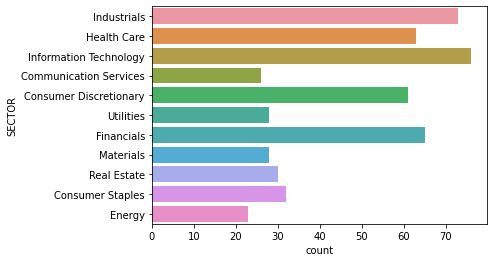

In [11]:
ax = sns.countplot(y="SECTOR", data=mdf)

In [12]:
mdf['FIRST_DATE_OHLC'] = pd.to_datetime(mdf['FIRST_DATE_OHLC']) 
type(mdf.FIRST_DATE_OHLC.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:xlabel='FIRST_DATE_OHLC'>

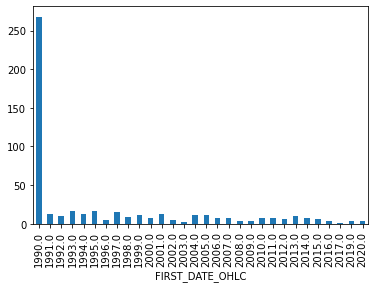

In [13]:
mdf.groupby(mdf["FIRST_DATE_OHLC"].dt.year).SECTOR.count().plot(kind="bar")

So we have most data starting from the 90's. now lets see how that is stacking up for the sector I am working in... financials. 

<AxesSubplot:xlabel='FIRST_DATE_OHLC'>

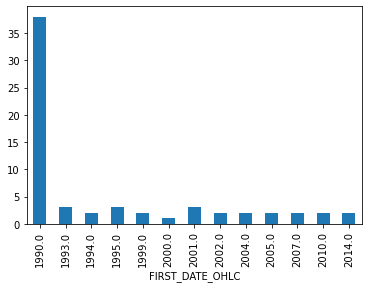

In [14]:
mdf_fin = mdf[mdf.SECTOR == 'Financials']
mdf_fin.groupby(mdf_fin["FIRST_DATE_OHLC"].dt.year).SECTOR.count().plot(kind="bar")

<AxesSubplot:xlabel='FIRST_DATE_OHLC'>

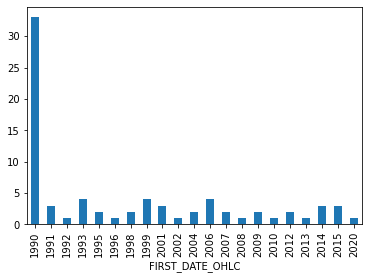

In [15]:
mdf_IT = mdf[mdf.SECTOR == 'Information Technology']
mdf_IT.groupby(mdf_IT["FIRST_DATE_OHLC"].dt.year).SECTOR.count().plot(kind="bar")

# Lets create a datast set on the financials dataframe 

In [16]:
mdf_fin.head(10)

,TICKER,FIRST_DATE_OHLC,LAST_DATE_OHLC,FILEPATH,SECTOR,FILEPATH_TECH_IND_CALC
11,AFL,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
22,ALL,1993-06-03,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
31,AXP,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
32,AIG,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
35,AMP,2005-09-15,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
43,AON,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
50,AJG,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
51,AIZ,2004-02-05,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
61,BAC,1990-01-02,2021-03-19,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...
64,BRK.B,NaT,NaN,C:\Users\Philipp\Google Drive\Code_for_bothCom...,Financials,C:\Users\Philipp\Google Drive\Code_for_bothCom...


and we are going to take the BAC (Bank of America). 

so the steps are the following:
- load the data from the disk
- chop off all the data that has a NaN because of calc. of some TA's
- get the prediction period cumsum of the log returns (convieniently, log returns can be summed). Note down if the stock would have gone up in the holding period or not --> our target variable


In [17]:
# load from disk and 
def loadTADataFromDisk(ticker):
    ticker_full_name = ticker + '_tech_ind_calculated'
    filepath = Path('../01_data/01_price_data/01_price_data_w_tech_indicators/').joinpath(ticker_full_name) 
    try: 
        df = pd.read_feather(filepath)
        return df
    except: 
        print("could not load ticker with TA from disk!")
        return None

In [18]:
BAC = loadTADataFromDisk('BAC')

In [19]:
def countNaN(df):
    columns = df.columns
    missingDF = pd.DataFrame(columns = ['COL', 'MISSING_NO', 'MISSING_RATIO'])
    entries = df.shape[0]
    for col in columns:
        missingNo = df[col].isna().sum()
        missingRatio = missingNo/entries
        to_append = [col, missingNo, missingRatio]
        df_length = len(missingDF)
        missingDF.loc[df_length] = to_append
        
    return missingDF

In [24]:
missingDict = countNaN(BAC.iloc[50:]);
missingDict.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190
COL,date,open,high,low,close,volume,Dividends,Stock Splits,LOGRET_1,EBSW_40_10,TRIMA_10,VIDYA_14,VWAP_D,VWMA_10,WCP,WMA_10,ZL_EMA_10,ALMA_10_6.0_0.85,DEMA_10,EMA_10,FWMA_10,HILO_13_21,HILOl_13_21,HILOs_13_21,HL2,HLC3,HMA_10,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,KAMA_10_2_30,LR_14,MCGD_10,MIDPOINT_2,MIDPRICE_2,OHLC4,PWMA_10,RMA_10,SINWMA_14,SMA_10,SSF_10_2,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,SWMA_10,T3_10_0.7,TEMA_10,RSI_14,RSX_14,RVGI_14_4,RVGIs_14_4,SLOPE_1,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25,UO_7_14_28,WILLR_14,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,CFO_9,CG_10,CMO_14,COPC_11_14_10,ER_10,BULLP_13,BEARP_13,FISHERT_9_1,FISHERTs_9_1,INERTIA_20_14,K_9_3,D_9_3,J_9_3,KST_10_15_20_30_10_10_10_15,KSTs_9,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MOM_10,PGO_14,PPO_12_26_9,PPOh_12_26_9,PPOs_12_26_9,PSL_12,PVO_12_26_9,PVOh_12_26_9,PVOs_12_26_9,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QQEs_14_5_4.236,ROC_10,ENTP_10,KURT_30,MAD_30,MEDIAN_30,QTL_30_0.5,SKEW_30,STDEV_30,VAR_30,Z_30,ADX_14,DMP_14,DMN_14,AMATe_LR_2,AMATe_SR_2,AROOND_14,AROONU_14,AROONOSC_14,CHOP_14_1_100,CKSPl_10_1_9,CKSPs_10_1_9,LDECAY_5,DEC_1,DPO_20,INC_1,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,QS_10,TTM_TRND_6,VTXP_14,VTXM_14,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,DCL_20_20,DCM_20_20,DCU_20_20,HW-MID,HW-UPPER,HW-LOWER,KCLe_20_2,KCBe_20_2,KCUe_20_2,MASSI_9_25,NATR_14,PDIST,RVI_14,THERMO_20_2_0.5,THERMOma_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TRUERANGE_1,UI_14,AD,ADOSC_3_10,OBV,OBV_min_2,OBV_max_2,OBVe_4,OBVe_12,AOBV_LR_2,AOBV_SR_2,CMF_20,EFI_13,EOM_14_100000000,MFI_14,NVI_1,PVI_1,PVOL,PVR,PVT
MISSING_NO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2658,3412,0,0,0,1,27,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,3472,4343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3796,4019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,3585,4230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MISSING_RATIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340115,0.436596,0.0,0.0,0.0,0.000128,0.003455,0.0,0.0,0.003327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444274,0.555726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485733,0.514267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001408,0.0,0.458733,0.541267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems like the dropping the first 50 entries should do the trick. 

In [21]:
imputeCols = missingDict[missingDict['MISSING_NO']>100].COL.to_list();
imputeCols

['HILOl_13_21',
 'HILOs_13_21',
 'SUPERTl_7_3.0',
 'SUPERTs_7_3.0',
 'QQEl_14_5_4.236',
 'QQEs_14_5_4.236',
 'PSARl_0.02_0.2',
 'PSARs_0.02_0.2']

In [63]:
BAC[imputeCols].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,7615,7616,7617,7618,7619,7620,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670,7671,7672,7673,7674,7675,7676,7677,7678,7679,7680,7681,7682,7683,7684,7685,7686,7687,7688,7689,7690,7691,7692,7693,7694,7695,7696,7697,7698,7699,7700,7701,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711,7712,7713,7714,7715,7716,7717,7718,7719,7720,7721,7722,7723,7724,7725,7726,7727,7728,7729,7730,7731,7732,7733,7734,7735,7736,7737,7738,7739,7740,7741,7742,7743,7744,7745,7746,7747,7748,7749,7750,7751,7752,7753,7754,7755,7756,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768,7769,7770,7771,7772,7773,7774,7775,7776,7777,7778,7779,7780,7781,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,7802,7803,7804,7805,7806,7807,7808,7809,7810,7811,7812,7813,7814,7815,7816,7817,7818,7819,7820,7821,7822,7823,7824,7825,7826,7827,7828,7829,7830,7831,7832,7833,7834,7835,7836,7837,7838,7839,7840,7841,7842,7843,7844,7845,7846,7847,7848,7849,7850,7851,7852,7853,7854,7855,7856,7857,7858,7859,7860,7861,7862,7863,7864
HILOl_13_21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.455829,4.455829,4.455829,4.363095,4.361421,4.371280,4.374442,4.373326,4.375186,4.377046,4.378720,4.387835,4.401414,4.419829,4.441406,4.465402,4.486979,4.504092,4.504092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.930739,3.857143,3.855934,3.859654,3.864676,3.875930,3.892857,3.917039,3.932664,3.942522,3.948010,3.956659,3.968471,3.980190,3.980190,3.980190,3.980190,3.980190,3.980190,NaN,NaN,NaN,NaN,4.106520,4.042783,4.047061,4.065848,4.086496,4.099702,4.112165,4.126674,4.140439,4.140439,NaN,4.335036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.866587,3.836124,3.830543,3.824963,3.823661,3.823661,NaN,3.867788,3.867788,3.867788,NaN,3.867488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.612258,NaN,NaN,NaN,NaN,NaN,NaN,3.571214,NaN,3.559044,NaN,3.539363,3.539363,3.539363,3.539363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.008603,2.004790,2.004139,2.003581,2.007394,2.018834,2.035993,2.054501,2.068545,2.083147,2.106678,2.135882,2.161923,2.188616,2.188616,2.228655,2.258557,2.298596,2.298596,2.298596,2.298596,2.425781,2.456380,2.484375,2.484375,2.484375,2.484375,2.484375,NaN,NaN,NaN,2.690505,2.550037,2.553943,2.561012,2.561012,2.585938,...,NaN,NaN,21.971726,NaN,NaN,NaN,NaN,NaN,NaN,20.957933,19.815476,19.853423,19.936756,20.104911,20.180060,20.180060,20.180060,20.459077,20.459077,20.459077,20.459077,20.459077,20.459077,21.123512,21.251488,21.401786,21.536458,21.536458,21.536458,21.536458,NaN,22.763221,22.098214,NaN,NaN,NaN,NaN,NaN,22.558894,NaN,21.793899,21.841518,21.8

The remaining columns are indicators that only have values if they are in a certained arrangement. Therefore, we can safely assume that we can use fill it with 0. 

In [26]:
BAC.fillna(0, inplace = True)

In [29]:
# countNaN(BAC).T

## generate the dependend variable

Ok. Now the data is halfway clean and organized. Now we want to generate a target variable for our ML model to train on.
We should actually do a simulation to see what our optimal holding period is, as well as incoporating our transaction costs. 
Due to our broker, we have a flatrate for trading. However, we pay on the bid ask spread, which we should incorporate in our backtest. 

In [ ]:
BAC['TARGET'] = 
    

In [35]:
A = BAC.LOGRET_1[:20]
A

0     0.000000
1     0.006836
2    -0.021484
3    -0.021484
4     0.005859
5     0.000000
6    -0.019531
7    -0.008789
8    -0.029297
9    -0.029297
10    0.035156
11    0.005859
12   -0.014648
13    0.037109
14   -0.016602
15    0.020508
16   -0.011719
17   -0.002930
18   -0.017578
19   -0.011719
Name: LOGRET_1, dtype: float16

In [41]:
A.rolling(5).sum()

0          NaN
1          NaN
2          NaN
3          NaN
4    -0.030273
5    -0.030273
6    -0.056641
7    -0.043945
8    -0.051758
9    -0.086914
10   -0.051758
11   -0.026367
12   -0.032227
13    0.034180
14    0.046875
15    0.032227
16    0.014648
17    0.026367
18   -0.028320
19   -0.023438
Name: LOGRET_1, dtype: float64

In [47]:
BAC.LOGRET_1.cumsum().iloc[4000]

1.895

In [48]:
BAC.iloc[4000]

date     2005-11-09 00:00:00
open                32.15625
high                32.40625
low                   32.125
close               32.21875
                ...         
NVI_1            1112.938477
PVI_1             1150.06897
PVOL             309570624.0
PVR                      1.0
PVT              362408480.0
Name: 4000, Length: 191, dtype: object